In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from torch.autograd import Variable
from tqdm import tqdm, trange
from train import ClassicTrainer, ClassicTrainer_feature, ADGTrainer, NNL2Trainer
from data_fetcher import dataset, dataset_CADG, dataset_test_only

data_path = '../processed_data'
id2name = {int(line.rstrip().split('-')[1]):'_'.join(line.split('-')[0].split()[1:]) for line in open('/home/songweig/sc/code/name2id13.txt').readlines()}
# id2name = {int(line.rstrip().split('-')[1]):'_'.join(line.split('-')[0].split()[1:]) for line in open('/home/songweig/sc/code/name2id39.txt').readlines()}


In [2]:
CAND_COLORS = np.array(['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f',
                '#ff7f00','#cab2d6','#6a3d9a', '#90ee90', '#9B870C', '#2f4554',
                '#61a0a8', '#d48265', '#c23531'])

In [3]:
def valid(domains, cutoff):
    ds = np.unique(domains)
    if ds.shape[0]<2:
        return False
    valid_domain_count = 0 # number of domain with more than cutoff samples
    for d in ds:
        if np.where(domains==d)[0].shape[0] >= cutoff:
            valid_domain_count += 1
    if valid_domain_count < 2:
        return False
    return True

In [4]:
def plot_pca_ct(representations, labels, domains, modelname, expname='scquery', cutoff=20):
    if not os.path.exists('../results/plots/%s/%s/pca2/'%(expname, modelname)):
        os.mkdir('../results/plots/%s/%s/pca2/'%(expname, modelname))
    ndomains = np.unique(domains)
    for z_target in ndomains:
        indeces = np.where((domains==z_target))[0]
        if len(indeces) == 0 or not valid(labels[indeces], cutoff):
            continue
        pca = PCA(n_components=2)
        pca.fit(representations[indeces])
        X_reduced = pca.transform(representations[indeces])
        plt.clf()
        fig, ax = plt.subplots()
        ax.scatter(X_reduced[:, 0], X_reduced[:, 1], s=5, alpha=0.6, c=labels[indeces])
        ax.set_xlabel("X1")
        ax.set_ylabel("X2")
        # plt.show()
        plt.savefig('../results/plots/%s/%s/pca2/%s_%s.png'%(expname, modelname, modelname, d.accessions_set[z_target]))
        plt.close()

In [51]:
def plot_pca_all(representations, labels, domains, modelname, expname='scquery', nlabels=39, cutoff=20):
    indeces = np.arange(representations.shape[0])
    pca = PCA(n_components=2)
    pca.fit(representations[indeces])
    X_reduced = pca.transform(representations[indeces])

    plt.clf()
    fig, ax = plt.subplots()
    ax.scatter(X_reduced[:, 0], X_reduced[:, 1], s=5, alpha=0.6, c=CAND_COLORS[-3:][domains[indeces]])
    ax.set_xlabel("X1")
    ax.set_ylabel("X2")
    plt.savefig('../results/plots/%s/pca_domains_%s.png'%(expname, modelname))
#     plt.show()
    
    plt.clf()
    fig, ax = plt.subplots()
    ax.scatter(X_reduced[:, 0], X_reduced[:, 1], s=5, alpha=0.6, c=CAND_COLORS[labels[indeces]])
    ax.set_xlabel("X1")
    ax.set_ylabel("X2")
    plt.savefig('../results/plots/%s/pca_labels_%s.png'%(expname, modelname))
#     plt.show()

In [5]:
def plot_pca(representations, labels, domains, modelname, expname='scquery', nlabels=39, cutoff=20):
    if not os.path.exists('../results/plots/%s/%s/pca/'%(expname, modelname)):
        os.mkdir('../results/plots/%s/%s/pca/'%(expname, modelname))
    for y_target in range(nlabels):
        indeces = np.where((labels==y_target))[0]
        if len(indeces) == 0 or not valid(domains[indeces], cutoff):
            continue
        pca = PCA(n_components=2)
        pca.fit(representations[indeces])
        X_reduced = pca.transform(representations[indeces])

        plt.clf()
        fig, ax = plt.subplots()
        ax.scatter(X_reduced[:, 0], X_reduced[:, 1], s=5, alpha=0.6, c=domains[indeces])
        ax.set_xlabel("X1")
        ax.set_ylabel("X2")
        # plt.show()
        plt.savefig('../results/plots/%s/%s/pca/%s_%s.png'%(expname, modelname, modelname, id2name[y_target]))
        plt.close()

In [6]:
def plot_tsne(representations, labels, domains, modelname, expname='scquery', nlabels=39, cutoff=20):
    if not os.path.exists('../results/plots/%s/%s/tsne/'%(expname, modelname)):
        os.mkdir('../results/plots/%s/%s/tsne/'%(expname, modelname))
    for y_target in range(nlabels):
        indeces = np.where((labels==y_target))[0]
        if len(indeces) == 0 or not valid(domains[indeces], cutoff):
            continue
        X_reduced = TSNE(n_components=2).fit_transform(representations[indeces])
        plt.clf()
        fig, ax = plt.subplots()
        ax.scatter(X_reduced[:, 0], X_reduced[:, 1], s=5, alpha=0.6, c=domains[indeces])
        ax.set_xlabel("X1")
        ax.set_ylabel("X2")
        # plt.show()
        plt.savefig('../results/plots/%s/%s/tsne/%s_%s.png'%(expname, modelname, modelname, id2name[y_target]))
        plt.close()

In [10]:
# extract the representations
def extract_rep(t, d, CDGN=False):
    representations = None
    labels = None
    domains = None
    n_iter = len(d._train_y)//batch_size
    t.D.eval()
    rng_state = np.random.get_state()
    for i in range(n_iter):
        x = d._train_X[i*batch_size:(i+1)*batch_size] 
        y = d._train_y[i*batch_size:(i+1)*batch_size]
        X = Variable(torch.cuda.FloatTensor(x))
        if CDGN:
            z = d._train_acc[i*batch_size:(i+1)*batch_size]
            f_X = t.D(X, X, target_layer=2)
        else:
            z = d._train_z[i*batch_size:(i+1)*batch_size]
            f_X = t.D(X, target_layer=2)
        if representations is None:
            representations = f_X.cpu().data.numpy()
            labels = y
            domains = z
        else:
            representations = np.concatenate((representations, f_X.cpu().data.numpy()), 0)
            labels = np.concatenate((labels, y), 0)
            domains = np.concatenate((domains, z), 0)

    # last batch
    x = d._train_X[(i+1)*batch_size:] 
    y = d._train_y[(i+1)*batch_size:]
    X = Variable(torch.cuda.FloatTensor(x))
    if CDGN:
        z = d._train_acc[(i+1)*batch_size:]
        f_X = t.D(X, X, target_layer=2)
    else:
        z = d._train_z[(i+1)*batch_size:]
        f_X = t.D(X, target_layer=2)
    representations = np.concatenate((representations, f_X.cpu().data.numpy()), 0)
    labels = np.concatenate((labels, y), 0)
    domains = np.concatenate((domains, z), 0)
    return representations, labels, domains


## NN and CDGN

In [79]:
#################### Settings ##############################
num_epochs = 100
batch_size = 256
dim1 = 1136
dim2 = 100
dim_domain = 40
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1"
data_path = '../processed_data'

# scquery
# d_dim = 20499
# dim_label = 39
# dataset_name = 39
# model_path = '/home/songweig/sc/results/models/0413'
# NN_name = 'ClassicNN_6_0.2268.pyt'
# CDGN_name = 'CDANN_0.02_17_0.3220_1.pyt'

# seurat
d_dim = 3000
dim_label = 13
model_path = '/home/songweig/sc/results/models/pancreas'
# dataset_name = 'pancreas0'
# NN_name = 'CDANN_pancreas_classicNN_d00.9980_0.6348_9.pyt'
# CDGN_name = 'CDANN_pancreas_d0_0.1_3_0.9929_0.7790_7.pyt'
# dataset_name = 'pancreas1'
# NN_name = 'CDANN_pancreas_classicNN_d10.9986_0.9295_3.pyt'
# CDGN_name = 'CDANN_pancreas_d1_0.2_1_0.9866_0.9436_0.pyt'
# dataset_name = 'pancreas2'
# NN_name = 'CDANN_pancreas_classicNN_d10.9979_0.9326_4.pyt'
# CDGN_name = 'old_bad_labelsize/CDANN_pancreas_d2_1_1_0.9877_0.8307_1.pyt'
# CDGN_name = 'CDANN_pancreas_d2_0.2_1_0.9831_0.8934_4.pyt'
# dataset_name = 'pancreas3'
# NN_name = 'CDANN_pancreas_classicNN_d30.9991_0.9514_1.pyt'
# CDGN_name = 'CDANN_pancreas_d3_1_1_0.9901_0.9561_7.pyt'
# dataset_name = 'pancreas4'
# NN_name = 'CDANN_pancreas_classicNN_d30.9991_0.9514_1.pyt'
# CDGN_name = 'CDANN_pancreas_d4_1_1_0.9920_0.9342_4.pyt'
dataset_name = 'pancreas5'
NN_name = 'CDANN_pancreas_classicNN_d50.9979_0.9263_3.pyt'
CDGN_name = 'CDANN_pancreas_d5_1_1_0.9903_0.9357_7.pyt'

# pbmc
# d_dim = 3000
# dim_label = 10
# model_path = '/home/songweig/sc/results/models/PBMC/'
# dataset_name = 'pbmc'
# NN_name = 'NN/NN_pbmc_0.9993_0.8663_7.pyt'
# CDGN_name = 'CDGN/CDANN_pbmc_0.01_0.9508_0.8720.pyt'
#################### Settings ##############################

d = dataset(data_path, batch_size, label_size=dim_label, dataset_name=dataset_name, validation=False)
domain_names = d.accessions_set
d_CDGN = dataset_CADG(data_path, batch_size, label_size=dim_label, dataset_name=dataset_name, validation=False)


t = ClassicTrainer(d_dim, dim1, dim2, dim_label, num_epochs, batch_size, use_gpu=True)
t_CDGN = ADGTrainer(d_dim, 5, 0.01, dim1, dim2, dim_label, dim_domain, num_epochs, batch_size, use_gpu=True)
t.dataset = d
t_CDGN.dataset = d_CDGN

t.D.load_state_dict(torch.load(os.path.join(model_path, NN_name)))
t_CDGN.D.load_state_dict(torch.load(os.path.join(model_path, CDGN_name)))


loading dataset...
loading dataset...
loading dataset: pancreas5
ClassicNN(
  (h1): Sequential(
    (0): Linear(in_features=3000, out_features=1136, bias=True)
    (1): Tanh()
  )
  (h2): Sequential(
    (0): Linear(in_features=1136, out_features=100, bias=True)
    (1): Tanh()
  )
  (o): Sequential(
    (0): Linear(in_features=100, out_features=13, bias=True)
  )
)
DANN_Siamese(
  (feature_extractor): Sequential(
    (0): Linear(in_features=3000, out_features=1136, bias=True)
    (1): Tanh()
    (2): Linear(in_features=1136, out_features=100, bias=True)
    (3): Tanh()
  )
  (domain_classifier): Sequential(
    (0): Linear(in_features=100, out_features=40, bias=True)
  )
  (label_classifier): Sequential(
    (0): Linear(in_features=100, out_features=13, bias=True)
  )
)


In [80]:
NN_representations, NN_labels, NN_domains = extract_rep(t, d, CDGN=False)
CDGN_representations, CDGN_labels, CDGN_domains = extract_rep(t_CDGN, d_CDGN, CDGN=True)

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

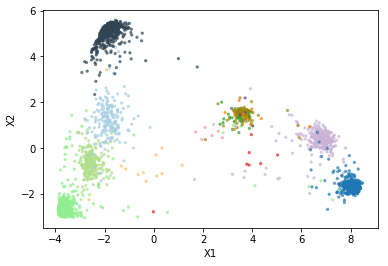

In [81]:
# plot_pca(NN_representations, NN_labels, NN_domains, 'NN', expname=dataset_name)
# plot_pca_ct(NN_representations, NN_labels, NN_domains, 'NN', expname=dataset_name)
# plot_tsne(NN_representations, NN_labels, NN_domains, 'NN', cutoff=5, expname=dataset_name)
plot_pca_all(NN_representations, NN_labels, NN_domains, 'NN', expname=dataset_name)
# plot_pca(CDGN_representations, CDGN_labels, CDGN_domains, 'CDGN2', expname=dataset_name)
# plot_pca_ct(CDGN_representations, CDGN_labels, CDGN_domains, 'CDGN', expname=dataset_name)
# plot_tsne(CDGN_representations, CDGN_labels, CDGN_domains, 'CDGN', cutoff=5, expname=dataset_name)
plot_pca_all(CDGN_representations, CDGN_labels, CDGN_domains, 'CDGN', expname=dataset_name)

## Seurat

In [5]:
d_Seurat = dataset_CADG(data_path, 128, label_size=13, dataset_name='pancreas0', validation=False)

loading dataset...
loading dataset: pancreas2


loading dataset...
loading dataset...
loading dataset...
loading dataset...
loading dataset...
loading dataset...


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

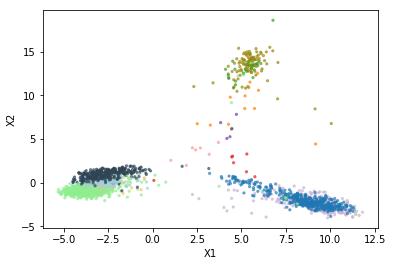

In [52]:
# dataset_name = 'large_seurat'
# dim_label = 39
dataset_name = 'seurat%d'
dim_label = 13
# dataset_name = 'pbmc'
# dim_label = 10
for i in range(6):
# i = 0
    d_Seurat = dataset(data_path, batch_size, label_size=dim_label, dataset_name=dataset_name%i, validation=False)
    Seurat_representations = d_Seurat._train_X
    Seurat_labels = d_Seurat._train_y
    Seurat_domains = d_Seurat._train_z
    # plot_pca(Seurat_representations, Seurat_labels, Seurat_domains, 'Seurat', expname=dataset_name)
    plot_pca_all(Seurat_representations, Seurat_labels.astype(int), Seurat_domains, 'Seurat', expname='pancreas%d'%i)
# plot_pca_ct(Seurat_representations, Seurat_labels, Seurat_domains, 'Seurat', expname=dataset_name)
# plot_tsne(Seurat_representations, Seurat_labels, Seurat_domains, 'Seurat', expname=dataset_name)

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

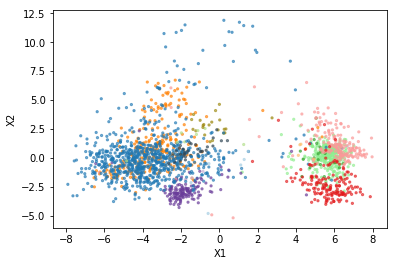

In [24]:
plot_pca_all(Seurat_representations, Seurat_labels.astype(int), Seurat_domains, 'Seurat', expname='pancreas0')


In [18]:
# Match the domain back to scquery domain compositions

Seurat_domains2 = np.zeros_like(Seurat_domains)
Seurat_d2n = {dn:np.sum(Seurat_domains==dn).astype(int) for dn in np.unique(Seurat_domains)}
scquery_n2d = {np.sum(d._train_z==dn).astype(int): dn for dn in np.unique(d._train_z)}

for dn in Seurat_d2n.keys():
    real_dn = scquery_n2d[Seurat_d2n[dn]]
    Seurat_domains2[Seurat_domains==dn] = real_dn

In [126]:
for y_target in range(39):
    indeces = np.where((Seurat_labels==y_target))[0]
    if len(indeces) == 0 or not valid(Seurat_domains[indeces], 20):
        continue
    indeces2 = np.where((d._train_y==y_target))[0] # scquery ids
    pca = PCA(n_components=2)
    pca.fit(Seurat_representations[indeces])
    X_reduced = pca.transform(Seurat_representations[indeces])
    plt.clf()
    fig, ax = plt.subplots()
    domain_first_ele = np.unique(d._train_z[indeces2], return_index=True)[1]
    domain_order = [d._train_z[indeces2][index] for index in sorted(domain_first_ele)]
    perm = np.hstack([np.where(Seurat_domains2[indeces]==dn)[0] for dn in domain_order]) # permutate the Seurat domains into target order
    color = np.hstack([[i]*np.where(Seurat_domains2[indeces]==dn)[0].shape[0] for i, dn in enumerate(domain_order)]) # color order
#     print(perm.shape)
    ax.scatter(X_reduced[:, 0][perm], X_reduced[:, 1][perm], s=5, alpha=0.6, c=color)
#     ax.scatter(X_reduced[:, 0][perm], X_reduced[:, 1][perm], s=5, alpha=0.6, c=Seurat_domains2[indeces][perm])
    ax.set_xlabel("X1")
    ax.set_ylabel("X2")
    # plt.show()
    plt.savefig('../results/plots/%s/%s/pca/%s_%s.png'%('scquery', 'Seurat', 'Seurat', id2name[y_target]))
    plt.close()

<Figure size 432x288 with 0 Axes>

In [121]:
ndomains = np.unique(Seurat_domains2)
for z_target in ndomains:
    indeces = np.where((Seurat_domains2==z_target))[0]
    if len(indeces) == 0 or not valid(Seurat_labels[indeces], 20):
        continue
    pca = PCA(n_components=2)
    pca.fit(Seurat_representations[indeces])
    X_reduced = pca.transform(Seurat_representations[indeces])

    plt.clf()
    fig, ax = plt.subplots()
    ax.scatter(X_reduced[:, 0], X_reduced[:, 1], s=5, alpha=0.6, c=Seurat_labels[indeces])
    ax.set_xlabel("X1")
    ax.set_ylabel("X2")
    # plt.show()
    plt.savefig('../results/plots/%s/%s/pca2/%s_%s.png'%('scquery', 'Seurat', 'Seurat', d.accessions_set[z_target]))
    plt.close()

<Figure size 432x288 with 0 Axes>

## MNN

In [6]:
d = dataset(data_path, 100, label_size=39, dataset_name=39, validation=False)

loading dataset...


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

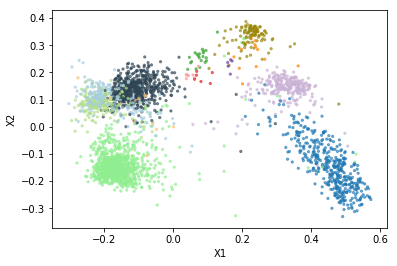

In [53]:
domain_train_ids = [np.where(d._train_z==i)[0] for i in range(99) if np.where(d._train_z==i)[0].shape[0]>20]
dataset_name = 'pancreas%d'
for i in range(6):
    MNN_representations = np.load('/home/songweig/sc/processed_data/MNN/%s/trainX.npy'%dataset_name%i)
    MNN_labels = np.load('/home/songweig/sc/processed_data/MNN/%s/trainy.npy'%dataset_name%i)
    MNN_domains = np.load('/home/songweig/sc/processed_data/MNN/%s/trainz.npy'%dataset_name%i)
# MNN_domains = np.hstack([d._train_z[ids] for ids in domain_train_ids])
    plot_pca_all(MNN_representations, MNN_labels, MNN_domains, 'MNN', expname=dataset_name%i)
#     plot_pca_ct(MNN_representations, MNN_labels, MNN_domains, 'MNN', expname=dataset_name%i)
#     plot_pca(MNN_representations, MNN_labels, MNN_domains, 'MNN', expname=dataset_name%i)
#     plot_tsne(MNN_representations, MNN_labels, MNN_domains, 'MNN', expname=dataset_name%i)

In [46]:
# Match the domain back to scquery domain compositions

MNN_domains2 = np.zeros_like(MNN_domains)
MNN_d2n = {dn:np.sum(MNN_domains==dn).astype(int) for dn in np.unique(MNN_domains)}
scquery_n2d = {np.sum(d._train_z==dn).astype(int): dn for dn in np.unique(d._train_z)}

for dn in MNN_d2n.keys():
    real_dn = scquery_n2d[MNN_d2n[dn]]
    MNN_domains2[MNN_domains==dn] = real_dn

In [8]:
plot_pca_ct(MNN_representations, MNN_labels, MNN_domains, 'MNN')
plot_pca(MNN_representations, MNN_labels, MNN_domains, 'MNN')
plot_tsne(MNN_representations, MNN_labels, MNN_domains, 'MNN')

<Figure size 432x288 with 0 Axes>

In [113]:
for y_target in range(39):
    indeces = np.where((MNN_labels==y_target))[0]
    if len(indeces) == 0 or not valid(MNN_domains[indeces], 20):
        continue
    indeces2 = np.where((d._train_y==y_target))[0] # scquery ids
    pca = PCA(n_components=2)
    pca.fit(MNN_representations[indeces])
    X_reduced = pca.transform(MNN_representations[indeces])
    plt.clf()
    fig, ax = plt.subplots()
    domain_first_ele = np.unique(d._train_z[indeces2], return_index=True)[1]
    domain_order = [d._train_z[indeces2][index] for index in sorted(domain_first_ele)]
    perm = np.hstack([np.where(MNN_domains2[indeces]==dn)[0] for dn in domain_order]) # permutate the MNN domains into target order
#     print(perm.shape)
    ax.scatter(X_reduced[:, 0][perm], X_reduced[:, 1][perm], s=5, alpha=0.6, c=MNN_domains2[indeces][perm])
    ax.set_xlabel("X1")
    ax.set_ylabel("X2")
    # plt.show()
    plt.savefig('../results/plots/%s/%s/pca/%s_%s.png'%('scquery', 'MNN', 'MNN', id2name[y_target]))
    plt.close()

<Figure size 432x288 with 0 Axes>

In [122]:
ndomains = np.unique(MNN_domains2)
for z_target in ndomains:
    indeces = np.where((MNN_domains2==z_target))[0]
    if len(indeces) == 0 or not valid(MNN_labels[indeces], 20):
        continue
    pca = PCA(n_components=2)
    pca.fit(MNN_representations[indeces])
    X_reduced = pca.transform(MNN_representations[indeces])

    plt.clf()
    fig, ax = plt.subplots()
    ax.scatter(X_reduced[:, 0], X_reduced[:, 1], s=5, alpha=0.6, c=MNN_labels[indeces])
    ax.set_xlabel("X1")
    ax.set_ylabel("X2")
    # plt.show()
    plt.savefig('../results/plots/%s/%s/pca2/%s_%s.png'%('scquery', 'MNN', 'MNN', d.accessions_set[z_target]))
    plt.close()

<Figure size 432x288 with 0 Axes>

## scVI

loading dataset...
loading dataset...
loading dataset...
loading dataset...
loading dataset...
loading dataset...


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

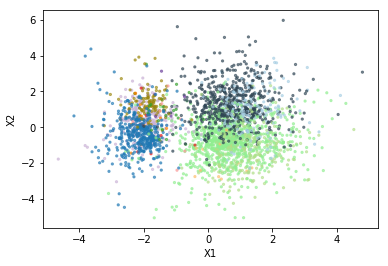

In [54]:
dataset_name = 'pancreas%d'
for i in range(6):
    d = dataset(data_path, batch_size, label_size=dim_label, dataset_name=dataset_name%i, validation=False)
    scVI_representations = np.load('/home/songweig/sc/processed_data/scVI/%s/trainX.npy'%dataset_name%i)
    scVI_labels = np.load('/home/songweig/sc/processed_data/scVI/%s/trainy.npy'%dataset_name%i)
    scVI_domains = d._train_z
    plot_pca_all(scVI_representations, scVI_labels, scVI_domains, 'scVI', expname=dataset_name%i)
#     plot_pca(scVI_representations, scVI_labels, scVI_domains, 'scVI', expname=dataset_name%i)
#     plot_pca_ct(scVI_representations, scVI_labels, scVI_domains, 'scVI', expname=dataset_name%i)
#     plot_tsne(scVI_representations, scVI_labels, scVI_domains, 'scVI', expname=dataset_name%i)